# Loading Data

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

WFLW_ROOT = "E:/pycharmgoesbrr/Project-Vitello-Tonnato/data/"

In [3]:
train_df = pd.read_csv(WFLW_ROOT + "WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt",
                       delimiter=" ", header=None)
test_df = pd.read_csv(WFLW_ROOT + "WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt",
                      delimiter=" ", header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,309.307007,538.369019,317.857345,560.120847,322.271739,583.014395,319.583872,606.149851,314.765287,629.015727,...,308,696,870,0,0,1,0,0,0,51--Dresses/51_Dresses_wearingdress_51_377.jpg
1,579.002991,167.764008,579.682070,179.841323,580.396685,191.916578,581.180930,203.987499,582.094807,216.049139,...,73,746,317,0,0,1,0,0,0,19--Couple/19_Couple_Couple_19_340.jpg
2,249.128006,175.462997,249.330412,188.417601,249.393073,201.373615,249.558448,214.328097,250.530592,227.243593,...,104,420,330,0,0,1,0,0,0,15--Stock_Market/15_Stock_Market_Stock_Market_...
3,812.989014,627.505005,813.713626,633.254430,814.450604,639.002281,815.212105,644.746929,816.041647,650.482018,...,582,901,697,0,0,0,0,0,1,44--Aerobics/44_Aerobics_Aerobics_44_543.jpg
4,507.287994,280.026001,507.360081,288.558285,507.747252,297.081106,508.773408,305.548694,510.611932,313.877793,...,212,632,379,0,0,0,0,0,1,5--Car_Accident/5_Car_Accident_Accident_5_938.jpg


In [4]:
train_raw_ds = tf.data.Dataset.from_tensor_slices(
    (train_df[range(196)].to_numpy().astype('float32'), train_df[range(196, 200)], train_df[206].to_numpy()))
test_raw_ds = tf.data.Dataset.from_tensor_slices(
    (test_df[range(196)].to_numpy().astype('float32'), test_df[range(196, 200)], test_df[206].to_numpy()))

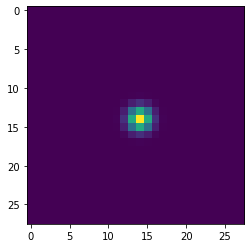

In [5]:
def gaussian(shape=(32, 32), peakValue=1.0, spread=1.0, n_landmarks=98):
    shape = tuple(shape)
    @tf.function(input_signature=[tf.TensorSpec((None, n_landmarks, 2))]) # batch, n_landmarks, 2
    def gaussian_fn(center):  # center[i] between 0-shape[i]
        center = tf.reshape(center, (-1, n_landmarks, 1, 2))
        grid = tf.stack(
            tf.meshgrid(
                tf.range(shape[1], dtype=tf.float32),
                tf.range(shape[1], dtype=tf.float32)
            ),
            axis=-1
        )
        unstacked = tf.reshape(grid, [1, 1, -1, 2])

        numerator = tf.square(center - unstacked)
        denominator = 2 * tf.square(spread)
        exponent = -tf.reduce_sum(numerator / denominator, axis=-1)
        unstacked_gaussian = peakValue * tf.exp(exponent)

        return tf.transpose(tf.reshape(unstacked_gaussian, (-1, n_landmarks) + shape), (0, 2, 3, 1))
    return gaussian_fn

plt.imshow(gaussian(shape=[28, 28], peakValue=1.0, spread=1.0, n_landmarks=1)(tf.constant([[[14, 14]]], dtype='float32')).numpy()[0, :, :, 0])
#gaussian(shape=[28, 28], peakValue=1.0, spread=1.0, n_landmarks=1)(tf.constant([[[14, 14]]], dtype='float32'))

In [6]:
def offset(shape=(32, 32), n_landmarks = 98):
    shape=tuple(shape)
    @tf.function(input_signature=[tf.TensorSpec((None, n_landmarks, 2))]) # batch, n_landmarks, 2
    def offset_fn(center):  # center between 0-1
        print("tracing offset")
        center = tf.reshape(center, (-1, n_landmarks, 1, 2))
        grid = tf.stack(
            tf.meshgrid(
                tf.range(shape[1], dtype=tf.float32),
                tf.range(shape[1], dtype=tf.float32)
            ),
            axis=-1
        )
        grid = (grid + 0.5) / shape[1]
        unstacked = tf.reshape(grid, [1, 1, -1, 2])
        distances = center - unstacked
        distances = (distances + 1) / 2
        x, y = tf.unstack(distances, axis=-1)
        x = tf.reshape(x, (-1, n_landmarks) + shape)
        y = tf.reshape(y, (-1, n_landmarks) + shape)
        return tf.transpose(x, (0, 2, 3, 1)), tf.transpose(y, (0, 2, 3, 1))
    return offset_fn

In [7]:
def load_image(landmarks, rect, filename):
    x_min, y_min, x_max, y_max = tf.unstack(rect)
    width = tf.cast(x_max - x_min, tf.dtypes.float32)
    height = tf.cast(y_max - y_min, tf.dtypes.float32)

    img = tf.io.read_file(WFLW_ROOT + "WFLW_images/" + filename)
    img = tf.image.decode_image(img)
    img = img[y_min: y_max, x_min:x_max, :]
    img = tf.image.resize_with_pad(img, 256, 256)

    landmarks = tf.reshape(landmarks, shape=(-1, 2))
    landmarks = landmarks - tf.cast(tf.stack([x_min, y_min]), tf.dtypes.float32)
    landmarks = landmarks / tf.maximum(width, height)

    padding = tf.stack([(height - width) / height, tf.constant(0.0)]) if height > width else tf.stack([tf.constant(0.0), (width - height) / width])
    padding = tf.reshape(padding / 2, (-1, 2))
    landmarks = landmarks + padding
    landmarks = landmarks * 256

    return img, landmarks

In [8]:
def gen_heatmaps(n_landmarks):
    gaussian_fn = gaussian(shape=(32, 32), peakValue=1.0, spread=1.0)
    offset_fn = offset(shape=(32, 32))
    @tf.function(input_signature=[tf.TensorSpec([None, n_landmarks, 2])])
    def gen_heatmaps(landmarks):
        print("tracing")
        heatmaps = gaussian_fn(landmarks * 32)
        x_offset, y_offset = offset_fn(landmarks)
        return tf.concat([heatmaps, x_offset, y_offset], axis=-1)
    return gen_heatmaps

In [9]:
from selfie2anime.augment import RandomAffineWithLandmarks
from tensorflow.keras import models as KM
from tensorflow.keras import layers as KL

In [10]:
inputs = [KL.Input((256, 256, 3), batch_size=8), KL.Input((98, 2), batch_size=8)]
outputs = RandomAffineWithLandmarks(rotation=0.5, translation=10, fill_mode="nearest", interpolation="bilinear")(inputs)
augment_fn = KM.Model(inputs, outputs)

In [11]:
gen_heatmaps_fn = gen_heatmaps(98)

In [12]:
def draw(img, heatmaps):
    plt.imshow(img.numpy().astype('int'))
    fig = plt.gcf()
    ax = fig.gca()
    for j in range(98):
        conf = tf.reshape(heatmaps[:, :, j], (-1))
        max_conf = tf.argmax(conf).numpy()
        center_y = max_conf // 32
        center_x = max_conf % 32
        offset_x = heatmaps[center_y, center_x, 98 + j] * 2 - 1
        offset_y = heatmaps[center_y, center_x, 98 + 98 + j]* 2 -1
        center_x = (center_x + 0.5) / 32 * 256 + offset_x * 256
        center_y = (center_y + 0.5) / 32 * 256 + offset_y * 256
        circle = plt.Circle((center_x, center_y), radius = 3)
        ax.add_patch(circle)

tracing
tracing offset
tf.Tensor(0.99987364, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


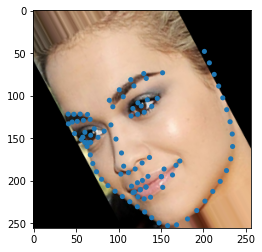

tf.Tensor(0.9998871, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


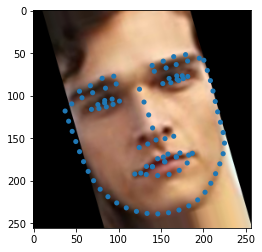

tf.Tensor(0.99980503, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


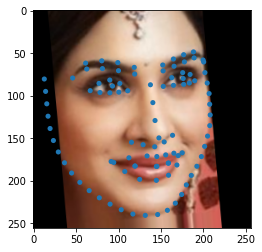

In [13]:
train_ds = train_raw_ds.map(load_image)
test_ds = test_raw_ds.map(load_image)

for i in train_ds.take(3):
    image, landmarks = i
    image, landmarks = augment_fn([tf.expand_dims(image, 0), tf.expand_dims(landmarks, 0)])
    heatmaps = gen_heatmaps_fn(landmarks / 256)

    print(tf.reduce_max(heatmaps), tf.reduce_min(heatmaps))

    image = image[0]
    heatmaps = heatmaps[0]

    draw(image, heatmaps)
    plt.show()

# Loss Function

In [24]:
from tensorflow.keras.losses import Loss

class AdaWingLoss(Loss):
    def __init__(self, omega=14, theta=0.5, eps=1, alpha=2.1, num_landmarks=98, landmark_weights=None, **kwargs):
        super(AdaWingLoss, self).__init__(**kwargs)
        self.omega = omega
        self.theta = theta
        self.eps = eps
        self.alpha = alpha
        self.num_landmarks = num_landmarks
        self.landmark_weights = landmark_weights

    def call(self, y_true, y_pred):
        A = self.omega * (1 / (1 + (self.theta / self.eps) ** (self.alpha - y_true))) * (self.alpha - y_true) * ((self.theta / self.eps) ** (self.alpha - y_true - 1)) / self.eps
        C = (self.theta * A - self.omega * tf.math.log(1 + (self.theta / self.eps)) ** (self.alpha - y_true))

        dilation_kernel = tf.zeros((3, 3, self.num_landmarks))
        weight = tf.nn.dilation2d(y_true[:, :, :, :self.num_landmarks], dilation_kernel, strides=(1, 1, 1, 1), padding="SAME", dilations=(1, 1, 1, 1), data_format="NHWC")
        weight = tf.maximum(tf.sign(weight - 0.2), 0.0)
        weight = weight * 10 + 1

        if self.landmark_weights is not None:
            weight = weight * self.landmark_weights

        weight = tf.tile(weight, (1, 1, 1, 3))

        abs_error = tf.abs(y_true - y_pred)
        linear =  A * abs_error - C
        nonlinear = self.omega * tf.math.log(1 + (abs_error / self.eps) ** (self.alpha - y_true))

        loss = tf.where(abs_error < self.theta, nonlinear, linear)

        loss = loss * weight

        return tf.reduce_sum(loss) / tf.reduce_sum(weight)

    def get_config(self):
        cfg = super(AdaWingLoss, self).get_config()
        cfg.update({'omega': self.omega,
                    'theta': self.theta,
                    'eps': self.eps,
                    'alpha': self.alpha,
                    'num_landmarks': self.num_landmarks,
                    "landmark_weights": self.landmark_weights})

# Model

In [25]:
import mobilenet
import tensorflow as tf
from tensorflow.keras import layers as KL
from tensorflow.keras import backend as K
from tensorflow.keras import models as KM
import tensorflow_addons as tfa
import tensorflow.keras.utils as KU
import ops
import datetime
from tqdm.notebook import tqdm_notebook

In [26]:
inputs = KL.Input(shape=(256, 256, 3))
C1, C2, C3, C4, C5 = mobilenet.mobilenetv3_large(inputs, include_preprocessing=True)
x = mobilenet.unet_block(C5, C4, 2.3, mobilenet.depth(256), 5, 1, 0.25, ops.HardSwish, 15)
x = mobilenet.unet_block(x, C3, 2.3, 294, 5, 1, 0.25, ops.HardSwish, 16)
x = KL.Activation('sigmoid')(x)
model = KM.Model(inputs, x)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_6[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

# Training

In [27]:
inputs = [KL.Input((256, 256, 3), batch_size=8), KL.Input((98, 2), batch_size=8)]
outputs = RandomAffineWithLandmarks(rotation=0.5, translation=10, fill_mode="nearest", interpolation="bilinear")(inputs)
augment_fn = KM.Model(inputs, outputs)

In [28]:
optimizer = tfa.optimizers.AdaBelief(learning_rate=1e-3, epsilon=1e-8, weight_decay=1e-4, rectify=False)
landmark_weights = np.ones(shape=(98,), dtype="float32")
landmark_weights[33:51] = 1.4
landmark_weights[60:75] = 1.6
landmark_weights[96:98] = 2.0
landmark_weights[76:87] = 1.6
landmark_weights[88:95] = 1.8
loss_fn = AdaWingLoss(landmark_weights=landmark_weights)

In [29]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
test_loss = tf.keras.metrics.Mean(name="test_loss")

In [30]:
checkpoint_path = "./landmarks_model/checkpoints"
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [34]:
@tf.function
def train_step(img, landmarks):
    img, landmarks = augment_fn((img, landmarks))
    heatmaps = gen_heatmaps_fn(landmarks / 256)

    with tf.GradientTape() as tape:
        predictions = model(img, training=True)
        loss = loss_fn(heatmaps, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

@tf.function
def test_step(img, landmarks):
    heatmaps = gen_heatmaps_fn(landmarks / 256)
    predictions = model(img, training=False)
    loss = loss_fn(heatmaps, predictions)
    test_loss(loss)

In [35]:
for epoch in (pbar := tqdm_notebook(range(100))):
    for (batch, (img, landmarks)) in enumerate(train_ds.batch(8)):
        train_step(img, landmarks)
        if batch % 100 == 0:
            pbar.set_description(f"epoch: {epoch} train_loss: {train_loss.result()}, batch: {batch}")

    for(batch, (img, landmarks)) in enumerate(test_ds.batch(8)):
        test_step(img, landmarks)

    print(f"Epoch: {epoch}, train_loss: {train_loss.result()}, test_loss: {test_loss.result()}")

    if epoch % 10 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')

    train_loss.reset_states()
    test_loss.reset_states()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, train_loss: 0.5715692639350891, test_loss: 0.33368968963623047
Saving checkpoint for epoch 0 at ./landmarks_model/checkpoints\ckpt-1
Epoch: 1, train_loss: 0.2251836508512497, test_loss: 0.19109655916690826
Epoch: 2, train_loss: 0.17209923267364502, test_loss: 0.1494741588830948
Epoch: 3, train_loss: 0.1508999615907669, test_loss: 0.16709797084331512
Epoch: 4, train_loss: 0.1315096914768219, test_loss: 0.12268790602684021
Epoch: 5, train_loss: 0.11529218405485153, test_loss: 0.11234705150127411
Epoch: 6, train_loss: 0.10514451563358307, test_loss: 0.11007752269506454
Epoch: 7, train_loss: 0.09820792824029922, test_loss: 0.10146772116422653
Epoch: 8, train_loss: 0.09557695686817169, test_loss: 0.12443086504936218
Epoch: 9, train_loss: 0.08965805172920227, test_loss: 0.08446159213781357
Epoch: 10, train_loss: 0.08668936043977737, test_loss: 0.08659133315086365
Saving checkpoint for epoch 10 at ./landmarks_model/checkpoints\ckpt-2
Epoch: 11, train_loss: 0.08321335166692734, test_

In [36]:
ckpt_save_path = ckpt_manager.save()
print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')

Saving checkpoint for epoch 99 at ./landmarks_model/checkpoints\ckpt-11


In [62]:
model.save("landmarks_model/model")

INFO:tensorflow:Assets written to: landmarks_model/model\assets


INFO:tensorflow:Assets written to: landmarks_model/model\assets


In [63]:
loaded_model = KM.load_model("landmarks_model/model")

In [64]:
ds = iter(test_ds.batch(1).take(10))

In [65]:
img, gt = next(ds)

In [66]:
out = loaded_model(img, training=False)

In [67]:
gt = gen_heatmaps_fn(gt / 256)

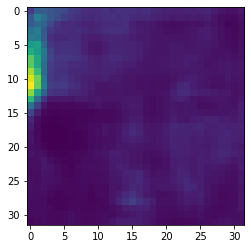

In [68]:
plt.imshow(out[0, :, : , 1].numpy())

In [69]:
loss_fn(gt, out)

<tf.Tensor: shape=(), dtype=float32, numpy=0.047754675>

In [70]:
gt.shape

TensorShape([1, 32, 32, 294])

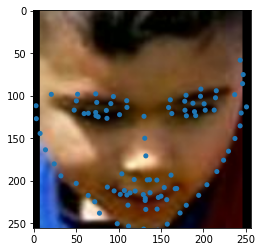

In [71]:
draw(img[0], out[0])

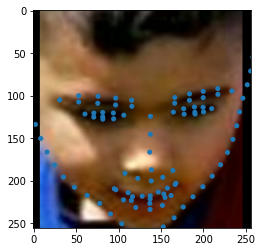

In [72]:
draw(img[0], gt[0])

In [251]:
img.shape

TensorShape([4, 256, 256, 3])

In [252]:
out = model.predict(img)

1/1 [==============================] - 1s 1s/step
